# A simple, yet complete, tutorial on how use the CCS_fit module to fit two-body interactions for solid Ne

In [1]:
# Load in the relevant packages

from ase.io import read,write
from ase.build import bulk
import numpy as np
import ase.db as db
from ase.visualize import view
from ase.calculators.lj import LennardJones
import matplotlib.pyplot as plt
from shutil import copyfile
from pymatgen.analysis import ewald
from ase.calculators.singlepoint import SinglePointCalculator
from pymatgen.core import Lattice, Structure

LJ=bulk('Ne','fcc',a=1.55)
LJ=LJ*[4,4,4]
calc_LJ = LennardJones()
LJ.calc = calc_LJ

charge_dict = {"Ne": +1}
LJ.charges = []
for elem in LJ.get_chemical_symbols():
    LJ.charges.append(charge_dict[elem])

Fit_on_forces=False  #Enable/disable option for fitting CCS potential to atomic forces. 

### Generate training data
Curvature Constrained Splines can be fitted to a reference data-set with energies (and optionally forces) of pre-calculated structures. In this example we generate the reference data-set using a Lennard-Jones potential. We use a LJ bulk structure that we randomly rattle and scale. 


In [2]:
orig_cell = LJ.get_cell()
orig_struc = LJ.copy()

displacement_magnitude=0.01
disp_steps=3
rounds=5

trainset_list="file_list_short_distance" # List of strucutres to include in the database (see below)
f = open(trainset_list, "w")
counter=1
for round in range(rounds):
    for scale in np.linspace(0.9, 1.0, 6):
        new_cell = orig_cell*scale
        new_struc = orig_struc.copy()
        new_struc.charges = LJ.charges
        new_struc.set_cell(new_cell)
        new_struc.calc = calc_LJ
        nrg = new_struc.get_potential_energy()
        
        for i in range(disp_steps):
            rattle_struc = new_struc.copy()
            rattle_struc.charges = LJ.charges
            rattle_struc.rattle(displacement_magnitude*i, seed=counter)
            
            lattice = Lattice(rattle_struc.get_cell())
            coords = rattle_struc.get_scaled_positions()
            ew_struct = Structure(
                lattice,
                rattle_struc.get_chemical_symbols(),
                coords,
                site_properties={"charge": rattle_struc.charges},
            )
            Ew = ewald.EwaldSummation(ew_struct, compute_forces=True)
            ES_energy = Ew.total_energy
            ES_forces = Ew.forces
            
            rattle_struc.calc = calc_LJ
            F=rattle_struc.get_forces()
            E=rattle_struc.get_potential_energy()     

            calculator = SinglePointCalculator(
                rattle_struc, energy=(E+ES_energy), free_energy=(E+ES_energy), forces=(F+ES_forces)
            )
            rattle_struc.calc = calculator
            rattle_struc.get_potential_energy()
            rattle_struc.get_forces()
                       
            # if nrg < 0: # We exclude structures that are unreasonably high in energy
            xyz_file=f"CALCULATED_DATA_SHORT/S{counter}.xyz"
            write(xyz_file,rattle_struc)
            print(xyz_file,file=f)
            counter += 1

f.close()

In [3]:
from ccs_fit.scripts.ccs_build_db import ccs_build_db

ccs_build_db(mode="CCS+Q",DFT_DB="LJ.db",file_list="file_list_short_distance",overwrite=True)

    Building data-bases: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:01<00:00, 92.72it/s]


In [4]:
from ccs_fit.scripts.ccs_fetch import ccs_fetch

charge_dict={"Ne":1.0}
ccs_fetch(mode="CCS+Q",DFT_DB="LJ.db", charge_dict=charge_dict, R_c=5., include_forces=Fit_on_forces)

    Fetching data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:32<00:00,  5.10it/s]


In [5]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS+Q",
        "merging"  : "False"
    },
    "Twobody": {
                "Ne-Ne": {
                        "Rcut": 5.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "full",
                        "range_width": 0.1,
                        "range_center": 1.39
                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [6]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

copyfile("CCS_params.json", "CCS_params_wall_nothing_fixed.json")

    Generating one-body information from training-set.
        Added elements:  ['Ne']
    Applying monotonic constraints for pair:  Ne-Ne


    Finding optimum switch: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 223/223 [00:19<00:00, 11.53it/s]


    The best switch is (193,) with rmse: 0.08624268084886971, corresponding to distances of [4.42] Å for element pairs ['Ne-Ne'].
Failed to build constrained aa and bb matrices.


'CCS_params_wall_nothing_fixed.json'

### Building dataset with short distances

In [7]:
orig_cell = LJ.get_cell()
orig_struc = LJ.copy()

displacement_magnitude=0.01
disp_steps=3
rounds=3

trainset_list="file_list_long_distance" # List of strucutres to include in the database (see below)
f = open(trainset_list, "w")
counter=1
for round in range(rounds):
    for scale in np.linspace(1.03, 1.10, 6):
        new_cell = orig_cell*scale
        new_struc = orig_struc.copy()
        new_struc.charges = LJ.charges
        new_struc.set_cell(new_cell)
        new_struc.calc = calc_LJ
        nrg = new_struc.get_potential_energy()
        
        for i in range(disp_steps):
            rattle_struc = new_struc.copy()
            rattle_struc.charges = LJ.charges
            rattle_struc.rattle(displacement_magnitude*i, seed=counter)
            
            lattice = Lattice(rattle_struc.get_cell())
            coords = rattle_struc.get_scaled_positions()
            ew_struct = Structure(
                lattice,
                rattle_struc.get_chemical_symbols(),
                coords,
                site_properties={"charge": rattle_struc.charges},
            )
            Ew = ewald.EwaldSummation(ew_struct, compute_forces=True)
            ES_energy = Ew.total_energy
            ES_forces = Ew.forces
            
            rattle_struc.calc = calc_LJ
            F=rattle_struc.get_forces()
            E=rattle_struc.get_potential_energy()     

            calculator = SinglePointCalculator(
                rattle_struc, energy=(E+ES_energy), free_energy=(E+ES_energy), forces=(F+ES_forces)
            )
            rattle_struc.calc = calculator
            rattle_struc.get_potential_energy()
            rattle_struc.get_forces()
                       
            # if nrg < 0: # We exclude structures that are unreasonably high in energy
            xyz_file=f"CALCULATED_DATA_LONG/S{counter}.xyz"
            write(xyz_file,rattle_struc)
            print(xyz_file,file=f)
            counter += 1

f.close()

In [8]:
from ccs_fit.scripts.ccs_build_db import ccs_build_db

ccs_build_db(mode="CCS",DFT_DB="LJ.db",file_list="file_list_long_distance",overwrite=True)

    Building data-bases: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:01<00:00, 94.05it/s]


### Generate the CCS_fit input file; structures.json
The next commands fetch the training set data from the ASE database containing the LJ structures and the corresponding energies. The reference data is called ``LJ.db`` since the reference energies and forces are obtained from a Lennard Jones potential.

In [9]:
from ccs_fit.scripts.ccs_fetch import ccs_fetch

charge_dict={"Ne":1.0}
ccs_fetch(mode="CCS+Q",DFT_DB="LJ.db", charge_dict=charge_dict, R_c=5.,include_forces=Fit_on_forces)

    Fetching data: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:17<00:00,  5.58it/s]


### Fit training data to Curvature Constrained Splines
Finally, the splines are fitted to the target defined in the structures.json input file. The splines can be restricted to be fully repulsive ("rep"), or have a turning point/switch ("sw"), which is defined by the "Swtype" key. A more comprehensive guide on the fitting options can be found in Advanced_Tutorials/Search_Mode.


In [10]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS+Q",
        "merging"  : "False"
    },
    "Twobody": {
                "Ne-Ne": {
                        "Rcut": 5.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "full",
                        "range_width": 0.1,
                        "range_center": 1.39
                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [11]:
#RUN FIT
from ccs_fit import ccs_fit
from shutil import copyfile

ccs_fit("CCS_input.json")

copyfile("CCS_params.json", "CCS_params_no_wall.json")

copyfile("xx.txt", "xx_no_wall.txt")

    Generating one-body information from training-set.
        Added elements:  ['Ne']
    Applying monotonic constraints for pair:  Ne-Ne


    Finding optimum switch: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 202/202 [00:07<00:00, 27.68it/s]


    The best switch is (17,) with rmse: 0.0016642115250171776, corresponding to distances of [1.32] Å for element pairs ['Ne-Ne'].
Failed to build constrained aa and bb matrices.


'xx_no_wall.txt'

### Validate your potential
Make sure your potential (at least) reproduce the data points in your training-set. Performing further tests on strucutres not included in the training set is recomended but not included in the tutorial.

In [12]:
from ccs_fit.scripts.ccs_validate import ccs_validate
ccs_validate(mode="CCS+Q",CCS_params="CCS_params.json",DFT_DB="LJ.db")

  0%|                                                                                                                                                                                                                                    | 0/99 [00:00<?, ?it/s]/home/thism292/anaconda3/envs/CCS_fit/lib/python3.9/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [01:04<00:00,  1.54it/s]


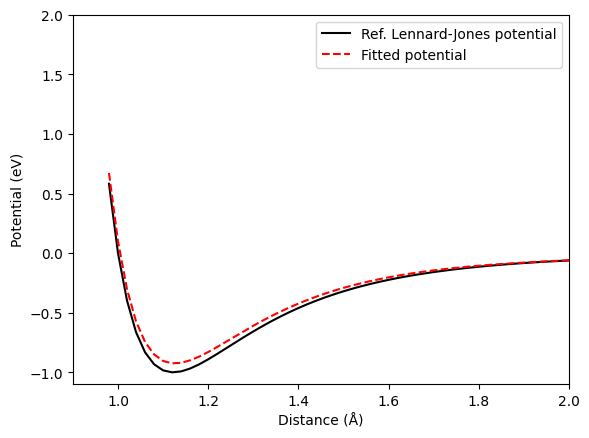

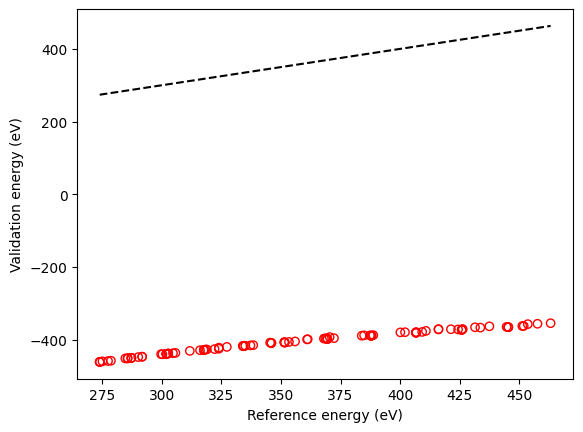

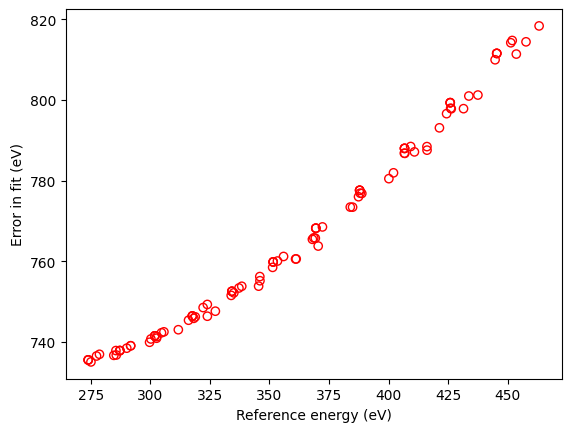

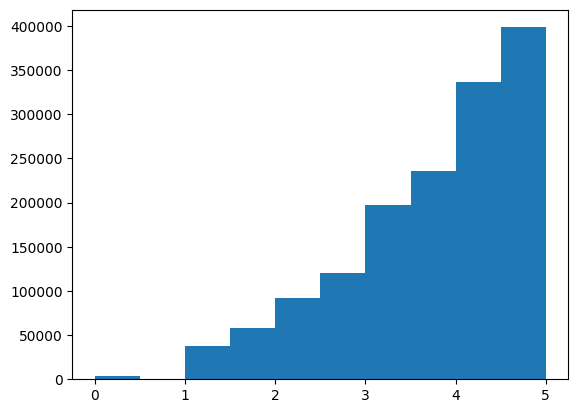

In [13]:
import json
import numpy as np
import matplotlib.pyplot as plt

with open("CCS_params.json", "r") as f:
    CCS_params = json.load(f)

with open("structures.json", "r") as f:
    training_set = json.load(f)

r=np.array(CCS_params["Two_body"]["Ne-Ne"]["r"])
e=CCS_params["Two_body"]["Ne-Ne"]["spl_a"]
e_LJ= 4 * ((1 / r) ** 12 - (1 / r) ** 6)
plt.xlim(0.9,2)
plt.ylim(-1.1, 2)
plt.xlabel('Distance (Å)')
plt.ylabel('Potential (eV)')
plt.plot(r,e_LJ,color='black',label="Ref. Lennard-Jones potential")
plt.plot(r,e,'--',color='red',label="Fitted potential")
plt.legend()
plt.show()

err=np.loadtxt("CCS_validate.dat")
plt.xlabel('Reference energy (eV)')
plt.ylabel('Validation energy (eV)')
plt.plot( [min(err[:,0]),max(err[:,0])],[min(err[:,0]),max(err[:,0])],'--',color='black'  )
plt.scatter(err[:,0],err[:,1],facecolors='none', edgecolors='red')
plt.show()
plt.xlabel('Reference energy (eV)')
plt.ylabel('Error in fit (eV)')
plt.scatter(err[:,0],err[:,2],facecolors='none', edgecolors='red')
plt.show()

try:
    err_F=np.loadtxt("CCS_error_forces.out")
    plt.xlabel('Reference force (eV/Å)')
    plt.ylabel('Fitted force (eV/Å)')
    plt.plot( [min(err_F[:,0]),max(err_F[:,0])],[min(err_F[:,0]),max(err_F[:,0])],'--',color='black')
    plt.scatter(err_F[:,0],err_F[:,1],facecolors='none', edgecolors='red',alpha=0.1 )
    plt.show()
except:
    pass

d=[]
for t in training_set["energies"]:
    d.extend(training_set["energies"][t]["Ne-Ne"])
    
plt.hist(d)
plt.show()

### Comparing fits without any constraints

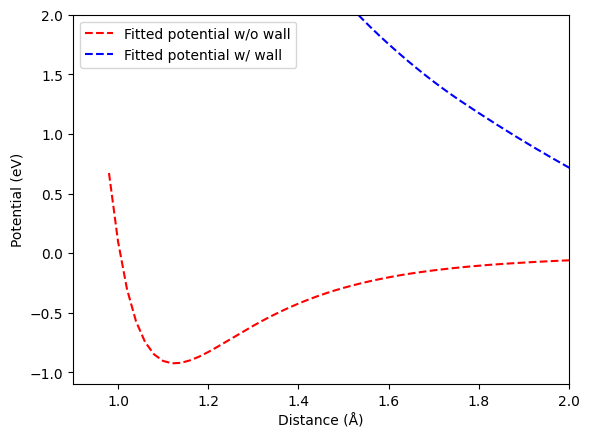

In [14]:
import json
import numpy as np
import matplotlib.pyplot as plt

with open("CCS_params_no_wall.json", "r") as f:
    CCS_params_no_wall = json.load(f)

with open("CCS_params_wall_nothing_fixed.json", "r") as f:
    CCS_params_wall = json.load(f)

r=np.array(CCS_params_no_wall["Two_body"]["Ne-Ne"]["r"])
r_wall=np.array(CCS_params_wall["Two_body"]["Ne-Ne"]["r"])
e=CCS_params_no_wall["Two_body"]["Ne-Ne"]["spl_a"]
e_wall = CCS_params_wall["Two_body"]["Ne-Ne"]["spl_a"]
e_LJ= 4 * ((1 / r) ** 12 - (1 / r) ** 6)
plt.xlim(0.9,2)
plt.ylim(-1.1, 2)
plt.xlabel('Distance (Å)')
plt.ylabel('Potential (eV)')
# plt.plot(r,e_LJ,color='black',label="Ref. Lennard-Jones potential")
plt.plot(r,e,'--',color='red',label="Fitted potential w/o wall")
plt.plot(r_wall,e_wall,'--',color='blue',label="Fitted potential w/ wall")
plt.legend()
plt.show()

### Adding constraints!

In [15]:
from ccs_fit.scripts.ccs_build_db import ccs_build_db

ccs_build_db(mode="CCS+Q",DFT_DB="LJ.db",file_list="file_list_short_distance",overwrite=True)

    Building data-bases: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:01<00:00, 94.53it/s]


In [ ]:
from ccs_fit.scripts.ccs_fetch import ccs_fetch

ccs_fetch(mode="CCS+Q",DFT_DB="LJ.db", charge_dict=charge_dict, R_c=5.,include_forces=Fit_on_forces)

    Fetching data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:33<00:00,  4.95it/s]


In [ ]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS+Q",
        "merging"  : "False",
        "separate_wall_opt": "True"
    },
    "Twobody": {
                "Ne-Ne": {
                        "Rcut": 5.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "full",
                        "range_width": 0.1,
                        "range_center": 1.39
                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [ ]:
#RUN FIT
from shutil import copyfile
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

copyfile("CCS_params.json", "CCS_params_wall.json")

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt

with open("CCS_params_no_wall.json", "r") as f:
    CCS_params_no_wall = json.load(f)

with open("CCS_params_wall.json", "r") as f:
    CCS_params_wall = json.load(f)

with open("CCS_params_wall_nothing_fixed.json", "r") as f:
    CCS_params_wall_nothing_fixed = json.load(f)
    
r=np.array(CCS_params_no_wall["Two_body"]["Ne-Ne"]["r"])
r_wall=np.array(CCS_params_wall["Two_body"]["Ne-Ne"]["r"])
r_wall_nothing_fixed=np.array(CCS_params_wall_nothing_fixed["Two_body"]["Ne-Ne"]["r"])
e=CCS_params_no_wall["Two_body"]["Ne-Ne"]["spl_a"]
e_wall = CCS_params_wall["Two_body"]["Ne-Ne"]["spl_a"]
e_wall_nothing_fixed = CCS_params_wall_nothing_fixed["Two_body"]["Ne-Ne"]["spl_a"]
e_LJ= 4 * ((1 / r_wall) ** 12 - (1 / r_wall) ** 6)

fig, axs = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(16,6))

axs[0].plot(r_wall,e_LJ,color='black',label="Ref. Lennard-Jones potential")
axs[0].plot(r,e,'--',color='red',label="Fitted potential w/o wall")
axs[0].plot(r_wall_nothing_fixed,e_wall_nothing_fixed,'--',color='green', label="Fitted potential w/ wall, nothing fixed")
axs[0].legend()

axs[1].plot(r_wall,e_wall,'--',color='blue',label="Fitted potential w/ wall, fixed coefficients")
axs[1].plot(r_wall_nothing_fixed,e_wall_nothing_fixed,'--',color='green',label="Fitted potential w/ wall, nothing fixed")
axs[1].legend()

axs[2].plot(r_wall,e_LJ,color='black',label="Ref. Lennard-Jones potential")
axs[2].plot(r,e,'--',color='red',label="Fitted potential w/o wall")
axs[2].plot(r_wall,e_wall,'--',color='blue',label="Fitted potential w/ wall, fixed coefficients")
axs[2].legend()

axs[0].set_xlim(0.9,2)
axs[0].set_ylim(-1.1, 2)
axs[1].set_xlabel('Distance (Å)')
axs[0].set_ylabel('Potential (eV)')


plt.show()